In [9]:
from itertools import combinations, permutations
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import math
from collections import defaultdict
from tqdm import tqdm  # Para barra de progresso (opcional)
from math import sqrt
import time
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [10]:
# Lê o arquivo CSV (ou Excel, se for o caso)
df = pd.read_excel('dadosEx1.xlsx').set_index('id')  # Se for CSV
# df = pd.read_excel('dados.xlsx')  # Se for Excel

# Mostra as primeiras linhas para verificar
print(df.head())

     x   y  demanda
id                 
0   42   6        0
1   28  23        8
2   33   5       15
3   45  13        9
4   14   3        6


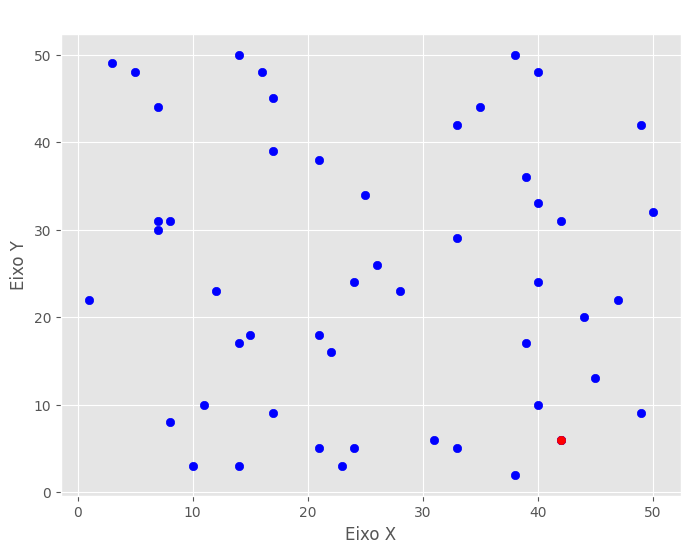

In [5]:
plt.figure(figsize=(8, 6))  # Define o tamanho do gráfico
plt.scatter(df['x'], df['y'], color='blue')
plt.scatter(df['x'].iloc[0], df['y'].iloc[0], color='red')

# Configurações do gráfico
plt.title('Gráfico de Pontos (x, y)')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.grid(True)  # Adiciona grade
#plt.legend()  # Mostra legenda

# Mostra o gráfico
plt.show()

In [11]:
def create_data_model(df, vehicle_capacity):
    """Cria a estrutura de dados para o problema."""
    data = {}
    data['distance_matrix'] = compute_distance_matrix(df)
    data['demands'] = df['demanda'].tolist()
    data['num_vehicles'] = calculate_min_vehicles(df, vehicle_capacity)
    data['vehicle_capacities'] = [vehicle_capacity] * data['num_vehicles']
    data['depot'] = 0  # O depósito é sempre o nó 0
    return data

def compute_distance_matrix(df):
    """Calcula a matriz de distâncias entre todos os pontos."""
    locations = df[['x', 'y']].values
    num_locations = len(locations)
    distance_matrix = np.zeros((num_locations, num_locations))
    
    for i in range(num_locations):
        for j in range(num_locations):
            if i != j:
                distance_matrix[i][j] = np.linalg.norm(locations[i] - locations[j])
    
    return distance_matrix.tolist()

def calculate_min_vehicles(df, capacity):
    """Calcula o número mínimo de veículos necessários."""
    total_demand = df['demanda'].sum() - df.loc[0, 'demanda']  # Remove demanda do depósito
    return int(np.ceil(total_demand / capacity))

def print_solution(data, manager, routing, solution):
    """Imprime a solução no console."""
    print(f'Custo total da solução: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = f'Rota do veículo {vehicle_id}:\n'
        route_distance = 0
        route_load = 0
        
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += f' {node_index} ->'
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        
        plan_output += f' {manager.IndexToNode(index)}\n'
        plan_output += f'Distância da rota: {route_distance}\n'
        plan_output += f'Carga da rota: {route_load}/{data["vehicle_capacities"][vehicle_id]}\n'
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    
    print(f'Distância total de todas as rotas: {total_distance}')
    print(f'Carga total transportada: {total_load}')

def get_routes(solution, routing, manager, num_vehicles):
    """Extrai as rotas da solução para análise posterior."""
    routes = []
    for vehicle_id in range(num_vehicles):
        route = []
        index = routing.Start(vehicle_id)
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

def main(df, vehicle_capacity=45, time_limit=30):
    """Resolve o problema de roteamento de veículos com capacidade."""
    # Instantiate the data problem.
    data = create_data_model(df, vehicle_capacity)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']),
        data['num_vehicles'],
        data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = time_limit
    search_parameters.log_search = True

    # Solve the problem.
    start_time = time.time()
    solution = routing.SolveWithParameters(search_parameters)
    elapsed_time = time.time() - start_time

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
        routes = get_routes(solution, routing, manager, data['num_vehicles'])
        
        # Criar DataFrame com resultados
        results = []
        for i, route in enumerate(routes):
            distance = 0
            load = sum(data['demands'][node] for node in route if node != 0)
            for j in range(len(route)-1):
                distance += data['distance_matrix'][route[j]][route[j+1]]
            
            results.append({
                'vehicle_id': i,
                'route': ' -> '.join(map(str, route)),
                'distance': distance,
                'load': f'{load}/{vehicle_capacity}',
                'num_clients': len(route)-2  # Exclui depósitos
            })
        
        results_df = pd.DataFrame(results)
        print(f"\nTempo de solução: {elapsed_time:.2f} segundos")
        return results_df
    else:
        print("Nenhuma solução encontrada!")
        return None

# Exemplo de uso:
if __name__ == '__main__':
    # Criar dados de exemplo (substitua pelo seu DataFrame)
    
    # Resolver o problema
    solution_df = main(df, vehicle_capacity=45, time_limit=10)
    
    if solution_df is not None:
        print("\nResumo das rotas:")
        print(solution_df)

Custo total da solução: 0
Rota do veículo 0:
 0 -> 3 -> 2 -> 1 -> 0
Distância da rota: 0
Carga da rota: 32/45

Rota do veículo 1:
 0 -> 6 -> 5 -> 0
Distância da rota: 0
Carga da rota: 40/45

Rota do veículo 2:
 0 -> 9 -> 8 -> 4 -> 0
Distância da rota: 0
Carga da rota: 38/45

Rota do veículo 3:
 0 -> 12 -> 11 -> 10 -> 0
Distância da rota: 0
Carga da rota: 40/45

Rota do veículo 4:
 0 -> 14 -> 13 -> 7 -> 0
Distância da rota: 0
Carga da rota: 42/45

Rota do veículo 5:
 0 -> 18 -> 17 -> 16 -> 15 -> 0
Distância da rota: 0
Carga da rota: 44/45

Rota do veículo 6:
 0 -> 21 -> 20 -> 19 -> 0
Distância da rota: 0
Carga da rota: 45/45

Rota do veículo 7:
 0 -> 24 -> 23 -> 22 -> 0
Distância da rota: 0
Carga da rota: 41/45

Rota do veículo 8:
 0 -> 28 -> 27 -> 26 -> 25 -> 0
Distância da rota: 0
Carga da rota: 44/45

Rota do veículo 9:
 0 -> 33 -> 32 -> 31 -> 30 -> 29 -> 0
Distância da rota: 0
Carga da rota: 44/45

Rota do veículo 10:
 0 -> 36 -> 35 -> 34 -> 0
Distância da rota: 0
Carga da rota: 45/

I0000 00:00:1748319031.500093   76219 search.cc:308] Start search (memory used = 93.51 MB)
I0000 00:00:1748319031.504995   76219 search.cc:308] Root node processed (time = 0 ms, constraints = 340, memory used = 93.71 MB)
I0000 00:00:1748319031.529803   76219 search.cc:308] Solution #0 (0, time = 25 ms, branches = 775, failures = 340, depth = 33, memory used = 94.54 MB, limit = 0%)
I0000 00:00:1748319031.530340   76219 search.cc:308] Finished search tree (time = 25 ms, branches = 775, failures = 374, memory used = 94.55 MB)
I0000 00:00:1748319031.530535   76219 search.cc:308] End search (time = 26 ms, branches = 775, failures = 374, memory used = 94.55 MB, speed = 29807 branches/s)
